In [1]:
import sys

# laptop
sys.path.append( '/home/greg/current/NMEG_utils/py_modules/' )
af_path = '/home/greg/sftp/eddyflux/Ameriflux_files/provisional/'
fig_path = '../figures/multiyear_figs/'
# UNM desktop
#sys.path.append( '..\\NMEG_utils\\py_modules\\' )
#af_path = 'C:\\Research_Flux_Towers\\Ameriflux_files\\'
#fig_path = 'figures\\multiyear_figs\\'

import load_nmeg as ld
import transform_nmeg as tr
import plot_nmeg as nmegplt
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
#import ipdb as ipdb

%matplotlib inline
sns.set_style("white")


In [2]:
# Years to load
start = 2007
end = 2014
# Sites to load (pulls list of AF sites from plot_nmeg module)
sites = nmegplt.sites
# Fill a dict with multiyear dataframes for each site in sites
hourly = { x : 
          ld.get_multiyr_aflx( 'US-' + x, af_path, gapfilled=True, startyear=start, endyear=end) 
          for x in sites }
    

Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2010_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2011_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2012_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2013_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Seg_2014_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2007_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2008_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_files/provisional/US-Ses_2009_gapfilled.txt
Parsing /home/greg/sftp/eddyflux/Ameriflux_

## Remove Mixed Conifer data after the fire

In [3]:
hourly[ 'Vcm' ] = hourly[ 'Vcm' ][ hourly[ 'Vcm' ].index < dt.datetime( 2013, 5, 3) ]
print(hourly[ 'Vcm' ].index)

DatetimeIndex(['2007-01-01 00:30:00', '2007-01-01 01:00:00',
               '2007-01-01 01:30:00', '2007-01-01 02:00:00',
               '2007-01-01 02:30:00', '2007-01-01 03:00:00',
               '2007-01-01 03:30:00', '2007-01-01 04:00:00',
               '2007-01-01 04:30:00', '2007-01-01 05:00:00', 
               ...
               '2013-05-02 19:00:00', '2013-05-02 19:30:00',
               '2013-05-02 20:00:00', '2013-05-02 20:30:00',
               '2013-05-02 21:00:00', '2013-05-02 21:30:00',
               '2013-05-02 22:00:00', '2013-05-02 22:30:00',
               '2013-05-02 23:00:00', '2013-05-02 23:30:00'],
              dtype='datetime64[ns]', length=111071, freq='30T', tz=None)


## Resample to daily frequency

In [4]:
# Resample all hourly dataframes in Hourly to daily and add to daily dict
daily = { x : 
         tr.resample_30min_aflx( hourly[x], freq='1D', 
                                c_fluxes=[ 'GPP', 'RECO', 'FC_F' ], 
                                le_flux=[ 'LE_F' ], 
                                avg_cols=[ 'TA_F', 'RH_F', 'SW_IN_F', 'RNET', 'VPD_F' ], 
                                sum_cols=[ 'P_F' ] , tair_col='TA_F' ) 
         for x in hourly.keys() }

# Convert this to a pandas panel
d = pd.Panel(daily)

In [5]:
# Daily files to Dan so we are working on the same data
d.Seg.to_csv('processed_data/US-Seg_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Ses.to_csv('processed_data/US-Ses_daily.csv', na_rep=-9999, date_format='%Y%m%d')
#d.Sen.to_csv('processed_data/US-Sen_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Wjs.to_csv('processed_data/US-Wjs_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Mpj.to_csv('processed_data/US-Mpj_daily.csv', na_rep=-9999, date_format='%Y%m%d')
#d.Mpg.to_csv('processed_data/US-Mpg_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Vcp.to_csv('processed_data/US-Vcp_daily.csv', na_rep=-9999, date_format='%Y%m%d')
d.Vcm.to_csv('processed_data/US-Vcm_daily.csv', na_rep=-9999, date_format='%Y%m%d')

## Set some plotting parameters

In [17]:
# Set x limits
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]


# Plot definition for one-site axis showing Multiyear mean + individual years in background
def plot_multiyr_lines( ax_in, clim, climcols, meancolor, 
                      syr=start, eyr=end,
                      indyrs=False, hilite=[None] ):
    stderr = False
    if type(climcols) == type(str()):
        climcols = [climcols,]
        stderr = True
        meancolor = [meancolor,]
    else:
        meancolor = [meancolor,'red','gray']
            
    # If requested, plot individual years
    if indyrs: 
        for i in range( syr, eyr+1 ):
            # If requested, highlight a particular year in red
            if i in hilite:
                hicolour='Red'
            else:
                hicolour=[0.7, 0.7, 0.7]
            # Plot the individual year line (mean + anomaly)
            ax_in.plot(clim.index, 
                       clim.allyr_mean + clim[ str(i) + '_anom' ], 
                       color=hicolour, lw=0.5)
    #ls = ['-', '--', ':']
    for j, col in enumerate(climcols):
        if j > 0:
            ax_in.plot(clim.index, clim[col], color=meancolor[j], lw=0.5)
        else:
            ax_in.plot(clim.index, clim[col], color=meancolor[j])
            
        if stderr:
            ax_in.plot(clim.index, clim[col] + clim.allyr_stderr, color=meancolor[j], alpha=.4)
            ax_in.plot(clim.index, clim[col] - clim.allyr_stderr, color=meancolor[j], alpha=.4)
    
# Plot definition for a 3 x 2 plot of multiyear mean fluxes
def plot_multiyr_mean_sites( clim_in, clim_cols, varname, texty, fighandle, ind_yrs=False,
                            xlims=[0,366], ylims=[-10,10], sitelist=sites,
                            sitenames=nmegplt.names, colors=nmegplt.palette, hilite_yr=None ):
    if type(clim_in) is list:
        clim = clim_in[0]
        clim2 = clim_in[1]
    else:
        clim = clim_in
        
    ax = list();
    for i, site in enumerate(sitelist):
        ax.append(fighandle.add_subplot(3, 2, i+1))
        plt.plot( xlims, [0, 0], ':k')
        plot_multiyr_lines( ax[i], clim[site], clim_cols, colors[i], hilite=[hilite_yr], indyrs=ind_yrs )
        if type(clim_in) is list:
            plot_multiyr_lines( ax[i], -clim2[site], clim_cols, colors[i], hilite=[hilite_yr], indyrs=ind_yrs )
            
        plt.ylim( ylims )
        plt.xlim( xlims )
        plt.text( 10, texty, sitenames[i], size=14  )
        plt.setp( ax[i].get_yticklabels(), fontsize=13)
        #ax[i].yaxis.set_ticks(np.arange(-8, 6, 4))
        if i < 2:
            plt.setp( ax[i].get_xticklabels(), visible=False)
        else:
            plt.setp( ax[i].get_xticklabels(), fontsize=14)
            
    for i in (0, 2, 4):
        ax[i].set_ylabel('Mean ' + varname + '\n$g\ C\ m^2$', fontsize=14)
        
    return ax

## Plot NEE timeseries

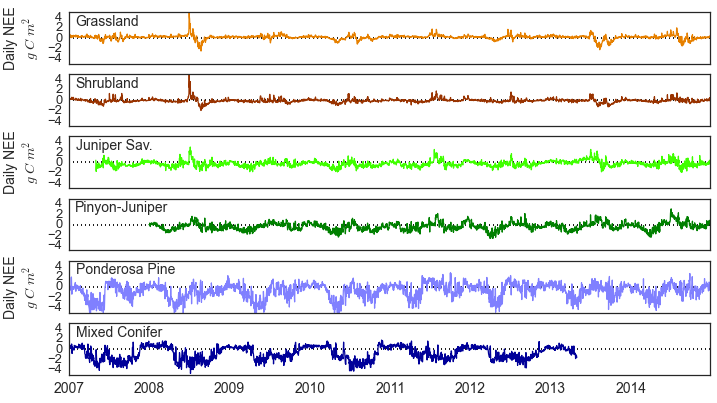

In [6]:
ylims = [ -5, 5 ]

fig1 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, 'FC_F_g_int', 2.5, fig1, 'Daily NEE\n$g\ C\ m^2$', ylims=ylims)

#plt.show()
fig1.savefig( fig_path + 'NMEG_daily_FC.svg')
fig1.savefig( fig_path + 'NMEG_daily_FC.png', dpi=200)

## Plot partitioned timeseries

* GPP is negative

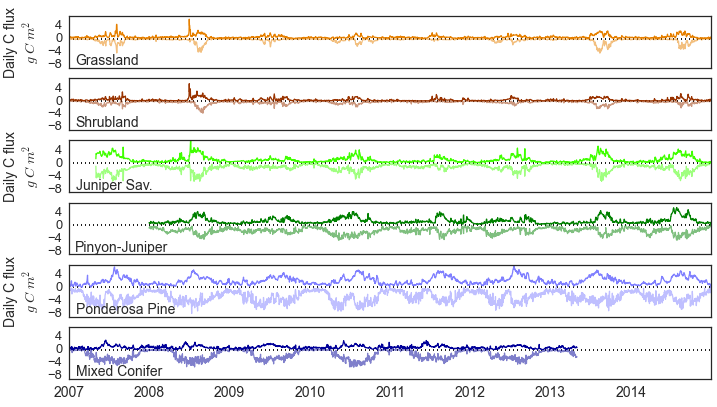

In [7]:
ylims = [ -9, 7 ]

fig2 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = nmegplt.plot_tseries( d, ['RECO_g_int', 'GPP_g_int'], -8, fig2, 'Daily C flux\n$g\ C\ m^2$', ylims=ylims)
for j in range(0,6):
    ax[j].yaxis.set_ticks(np.arange(-8, 6, 4))

#plt.show()
fig2.savefig( fig_path + 'NMEG_daily_part.svg')
fig2.savefig( fig_path + 'NMEG_daily_part.png', dpi=200)


## Calculate multi-year means and anomaly

In [9]:
# Get climatologies
import math
def get_climatology( ser ):
    # Create dataframes to hold raw year data and climatology calculations
    raw_years = pd.DataFrame( index = range( 1, 367 ))
    climatology = raw_years.copy()
    # Put 1 day values for each year in a column
    for i in np.unique(ser.index.year):
        year_vals = ser[ ser.index.year==i ].values
        raw_years[ str(i) ] = np.nan
        raw_years[ str(i) ][ 0:len(year_vals)] = year_vals
    # Get summary stats each day of the year
    climatology[ 'allyr_mean' ] = raw_years.mean(axis=1)
    climatology[ 'allyr_stdev' ] = raw_years.std(axis=1)
    climatology[ 'allyr_stderr' ] = climatology.allyr_stdev / math.sqrt( len(np.unique(ser.index.year))-1 )
    climatology[ 'predrght_mean' ] = raw_years[['2007', '2008', '2009', '2010']].mean(axis=1)
    climatology[ 'drght_mean' ] = raw_years[['2011', '2012']].mean(axis=1)
    climatology[ 'postdrght_mean' ] = raw_years[['2013', '2014']].mean(axis=1)
    # Calculate anomalies from allyear mean for drought-post-drought
    climatology[ 'predrght_mean_anom' ] = climatology.predrght_mean - climatology.allyr_mean
    climatology[ 'drght_mean_anom' ] = climatology.drght_mean - climatology.allyr_mean
    climatology[ 'postdrght_mean_anom' ] = climatology.postdrght_mean - climatology.allyr_mean
    climatology[ 'drght_mean_preanom' ] = climatology.drght_mean - climatology.predrght_mean
    climatology[ 'postdrght_mean_preanom' ] = climatology.postdrght_mean - climatology.predrght_mean

    # Calculate the anomaly of the original series
    # (subtract multiyear mean)
    anom = ser.copy()
    anom_norm = ser.copy()
    for i in np.unique(ser.index.year):
        # column for each year
        climatology[ str(i) ] = raw_years[ str(i )]
        climatology[ str(i) + '_anom' ] = raw_years[ str(i )] - climatology.allyr_mean
        climatology[ str(i) + '_preanom' ] = raw_years[ str(i )] - climatology.predrght_mean
        # entire timeseries
        anom[ anom.index.year==i ] = ser[ ser.index.year==i ] - climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values
        anom_norm[ anom_norm.index.year==i ] = ((ser[ ser.index.year==i ] - 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values) / 
                                                climatology.allyr_mean[0:len(ser[ ser.index.year==i ])].values)
    
    return anom, anom_norm, climatology

## For FC, GPP, RECO, VPD, P

In [10]:
# Mean NEE, GPP, REC), PRECIP, VPD and anomalies
# Create dictionaries for each
fc_anom, fc_anom_n, fc_clim = dict(), dict(), dict()
gpp_anom, gpp_anom_n,  gpp_clim = dict(), dict(), dict()
re_anom, re_anom_n,  re_clim = dict(), dict(), dict()
p_anom, p_anom_n,  p_clim = dict(), dict(), dict()
vpd_anom, vpd_anom_n,  vpd_clim = dict(), dict(), dict()
# Loop through sites, calculate climatology and fill dictionaries
for site in sites:
    fc_anom[ site ], fc_anom_n[ site ], fc_clim[ site ] = get_climatology( d[ site ]['FC_F_g_int' ] )
    gpp_anom[ site ], gpp_anom_n[ site ], gpp_clim[ site ] = get_climatology( d[ site ][ 'GPP_g_int' ] )
    re_anom[ site ], re_anom_n[ site ], re_clim[ site ] = get_climatology( d[ site ][ 'RECO_g_int' ] )
    p_anom[ site ], p_anom_n[ site ], p_clim[ site ] = get_climatology( d[ site ][ 'P_F' ] )
    vpd_anom[ site ], vpd_anom_n[ site ], vpd_clim[ site ] = get_climatology( d[ site ][ 'VPD_F' ] )

## Plot multiyear C flux means

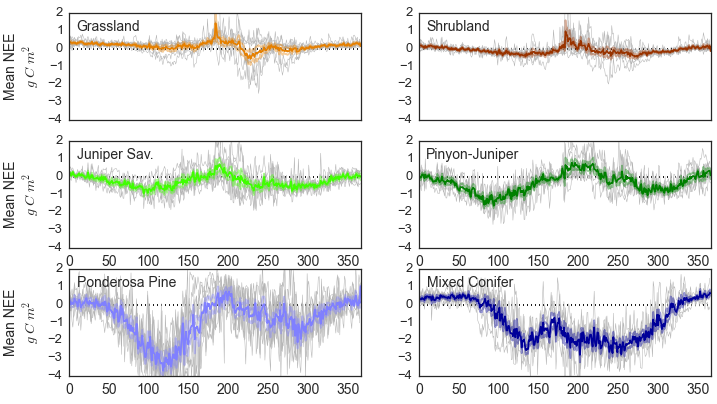

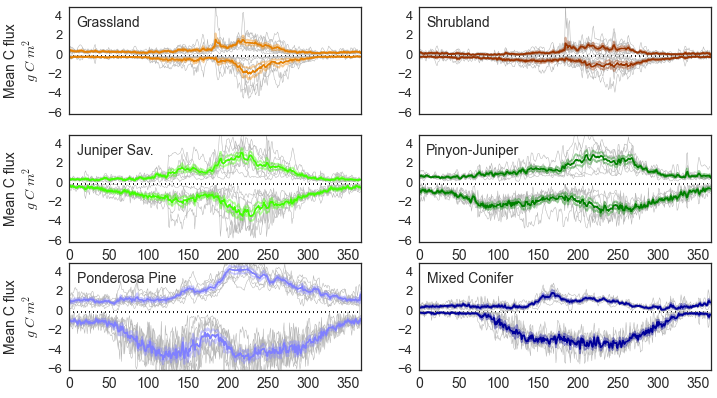

In [18]:
# Plot NEE
ylims = [ -4, 2 ]
xlims = [ 0, 366 ]
highlight_year = [2011]
fig3 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( fc_clim, 'allyr_mean', 'NEE', 1, fig3, ind_yrs=True,
                        ylims=ylims)     
fig3.savefig( fig_path + 'NMEG_mean_NEE.svg')
fig3.savefig( fig_path + 'NMEG_mean_NEE.png', dpi=200)

# Plot GPP
#ylims = [ 0, 6 ]

#fig4 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
#plot_multiyr_mean_sites( gpp_clim, 'GPP', 5, fig4, 
#                        ylims=ylims, hilite_yr=highlight_year)   
#fig4.savefig( fig_path + 'NMEG_mean_GPP.svg')
#fig4.savefig( fig_path + 'NMEG_mean_GPP.tiff', dpi=200)

# Plot RECO
#ylims = [ 0, 5 ]
#fig5 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
#plot_multiyr_mean_sites( re_clim, 'RECO', 4, fig5, 
#                        ylims=ylims, hilite_yr=highlight_year)
#fig5.savefig( fig_path + 'NMEG_mean_RECO.svg')
#fig5.savefig( fig_path + 'NMEG_mean_RECO.tiff', dpi=200)

# Plot RECO and GPP
ylims = [ -6, 5 ]
fig6 = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_multiyr_mean_sites( [re_clim, gpp_clim], 'allyr_mean', 'C flux', 3, fig6,
                        ylims=ylims, ind_yrs=True)
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.svg')
fig6.savefig( fig_path + 'NMEG_mean_RECOGPP.png', dpi=200)

## Plot multiyear C flux means for pre/post/drought

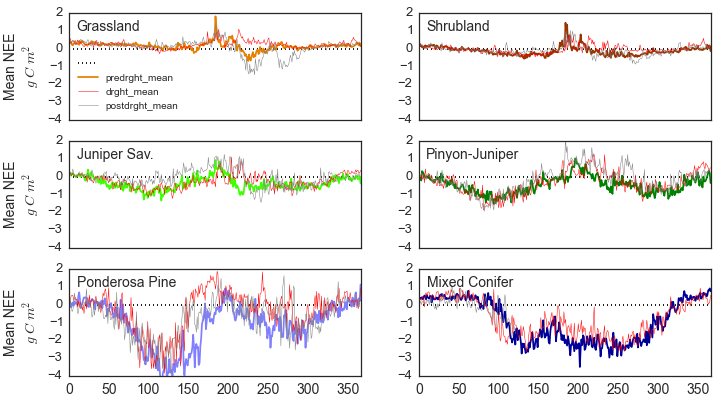

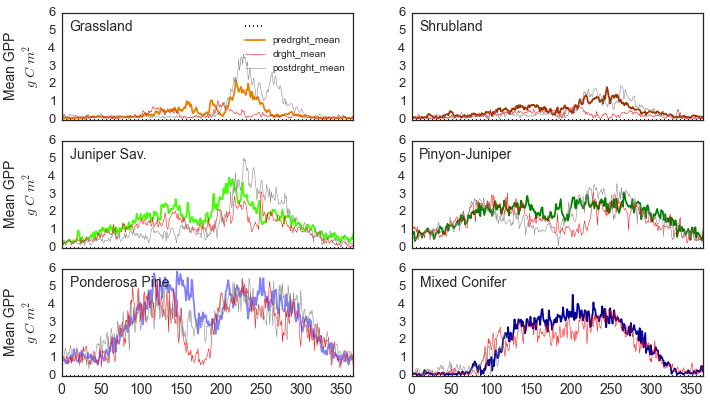

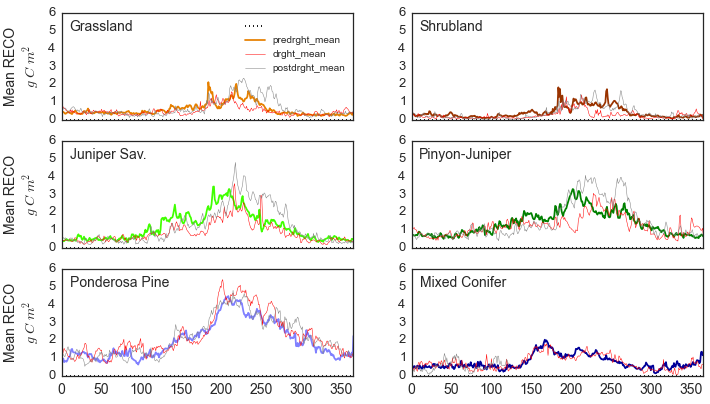

In [14]:
ylims = [ -4, 2 ]

figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( fc_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'NEE', 1, figX, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='lower left')

ylims = [ 0, 6 ]
figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( gpp_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'GPP', 5, figY, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])
ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
ax = plot_multiyr_mean_sites( re_clim, ['predrght_mean','drght_mean','postdrght_mean'],
                             'RECO', 5, figZ, ind_yrs=False,
                             ylims=ylims, hilite_yr=[None])

ax[0].legend(['','predrght_mean','drght_mean','postdrght_mean'], loc='upper right')

## Limit to growing season

The next several plots are limited to growing season only.

In [13]:
startseas = 90
endseas = 300

## Plot mean daily values for all drought periods

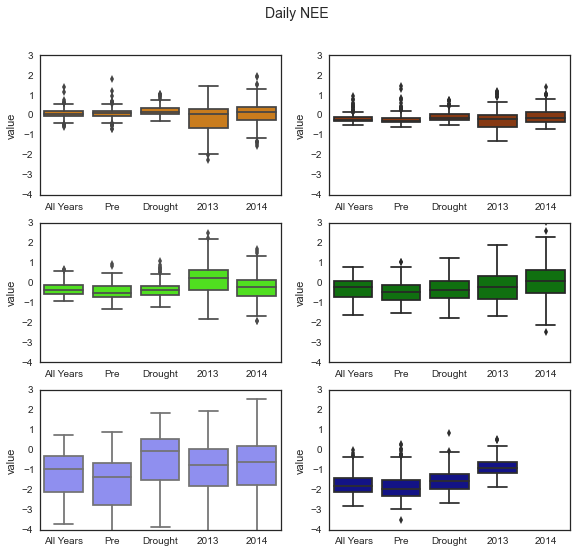

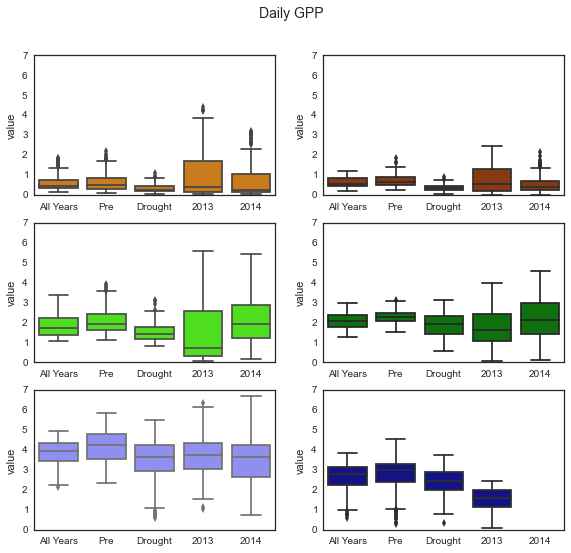

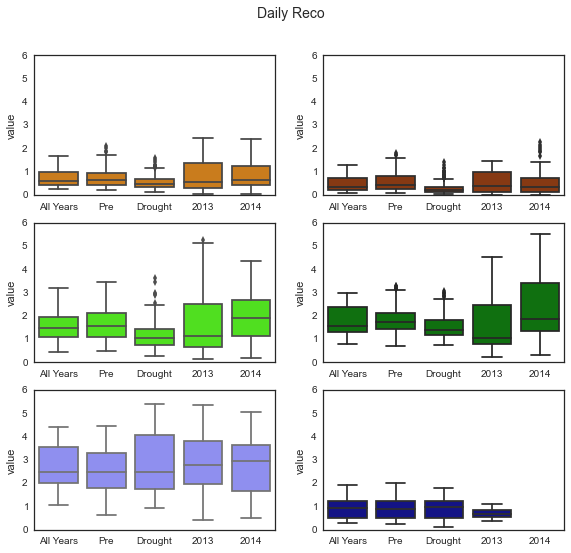

In [14]:
def plot_drought_dist( clim, fig, y_limit, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        if anom:
            #subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
            #                       'postdrght_mean_anom']])
            subset = pd.melt(data[['predrght_mean_anom', 'drght_mean_anom',
                                   '2013_anom', '2014_anom']])
            xlabels = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            subset = pd.melt(data[['drght_mean_preanom',
                                   '2013_preanom', '2014_preanom']])
            xlabels = ['Drought', '2013', '2014']
        else:
            #subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
            #                       'postdrght_mean']])
            subset = pd.melt(data[['allyr_mean','predrght_mean', 'drght_mean',
                                   '2013', '2014']])
            xlabels = ['All Years', 'Pre', 'Drought', '2013', '2014']
        
        ax = fig.add_subplot(3, 2, i+1)    
        sns.boxplot(x='variable', y='value', data=subset, color=nmegplt.palette[i])
        ax.set_xlabel('')
        #ax.set_xticklabels(['Pre', 'Drought', 'Post'])
        ax.set_xticklabels(xlabels)
        ax.set_ylim(y_limit)

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-4, 3])
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [0, 7])
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [0, 6])
plt.suptitle('Daily Reco', size=14)

## Anomalies w/ respect to all year mean

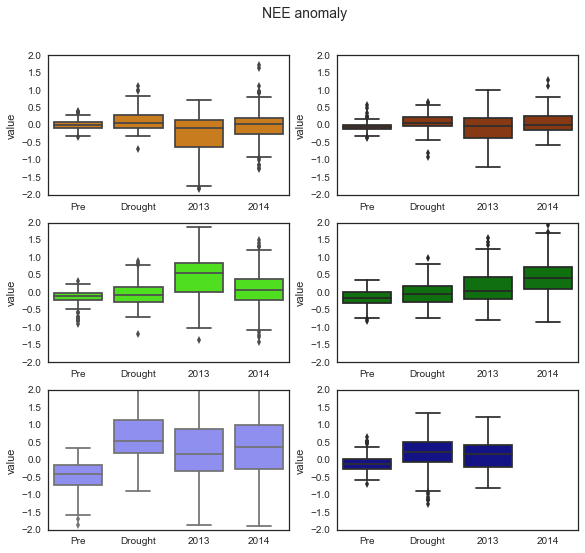

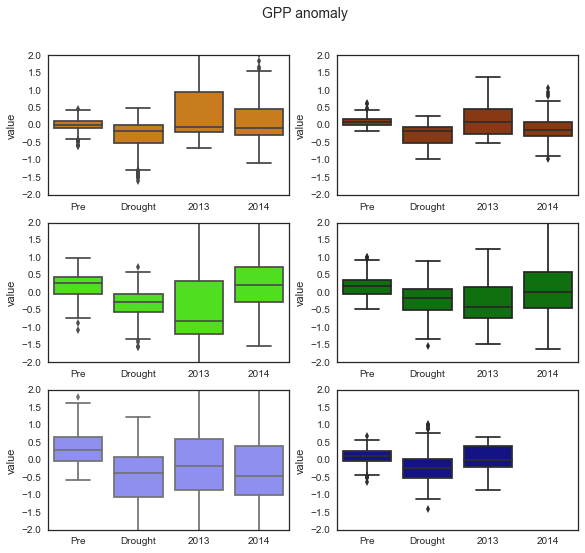

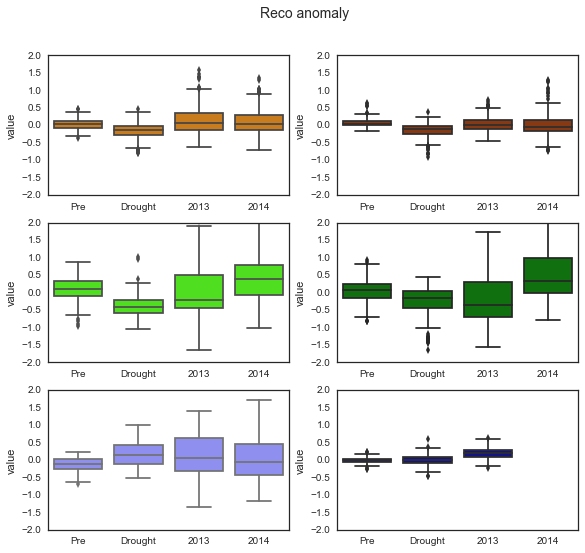

In [15]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], anom=True)
plt.suptitle('Reco anomaly', size=14)

## Anomalies w/ respect to pre-drought mean (2007-2010)

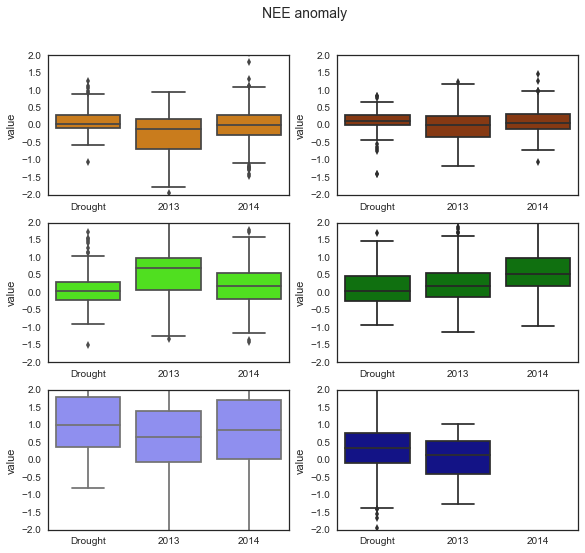

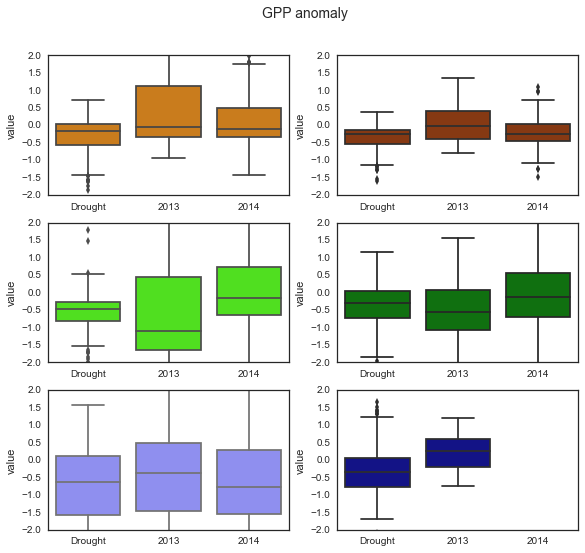

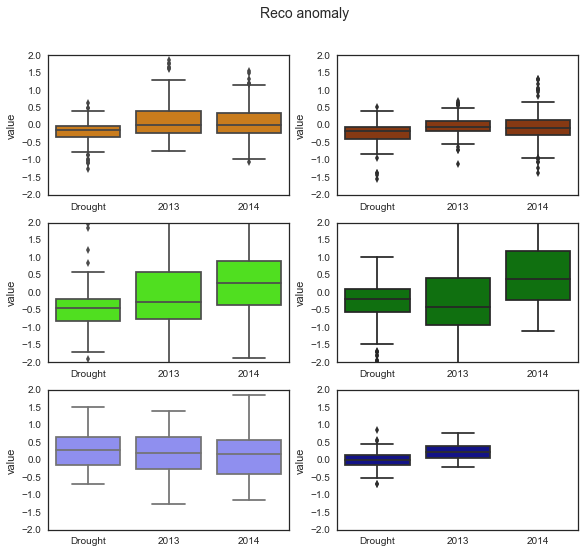

In [16]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( fc_clim, figX, [-2, 2], preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( gpp_clim, figY, [-2, 2], preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_dist( re_clim, figZ, [-2, 2], preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily flux values

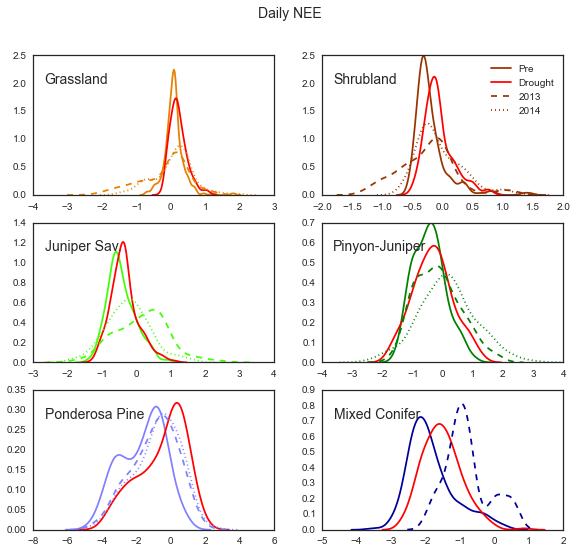

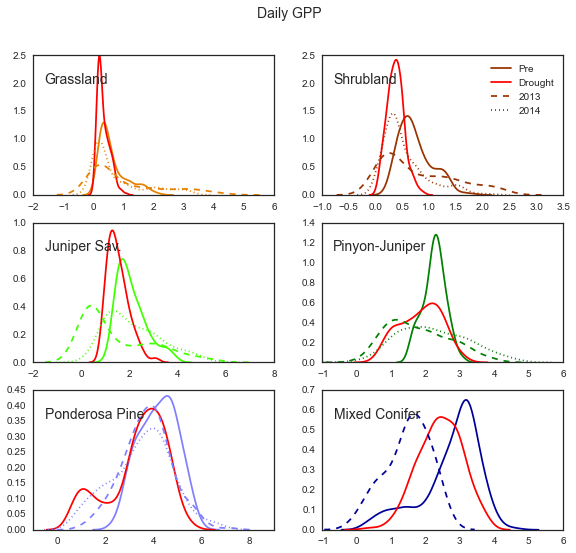

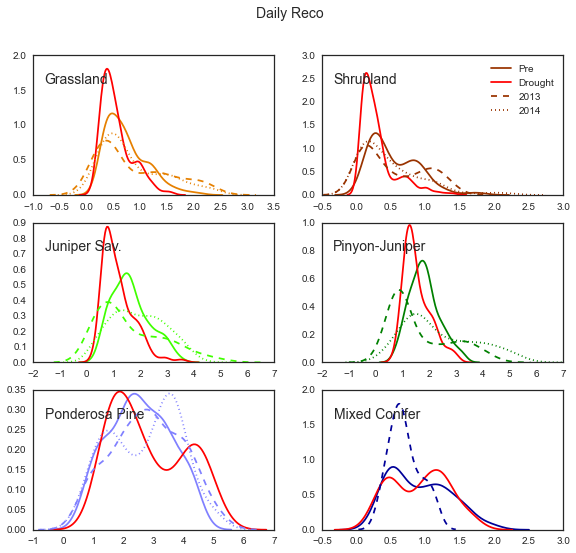

In [19]:
def plot_drought_kde( clim, fig, anom=False, preanom=False ):
    for i, site in enumerate(sites):
        # Limit to growing season only
        data = clim[site].iloc[startseas:endseas]
        ax = fig.add_subplot(3, 2, i+1)
        if anom:
            ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean_anom','drght_mean_anom','2013_anom','2014_anom']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        elif preanom:
            ax.set_xlim([-2, 2])
            kde_vars = ['drght_mean_preanom','2013_preanom','2014_preanom']
            legend_label = ['Drought', '2013', '2014']
        else:
            #ax.set_xlim([-2, 2])
            kde_vars = ['predrght_mean','drght_mean','2013','2014']
            legend_label = ['Pre', 'Drought', '2013', '2014']
        
        if site!='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[i])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[i], ls='--')
            sns.kdeplot(data[kde_vars[3]].dropna(), legend=False, color=nmegplt.palette[i], ls=':')
        elif site!='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[i])
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[i], ls='--')
        elif site=='Vcm' and preanom==False:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color=nmegplt.palette[i])
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[2]].dropna(), legend=False, color=nmegplt.palette[i], ls='--')
        elif site=='Vcm' and preanom==True:
            sns.kdeplot(data[kde_vars[0]].dropna(), legend=False, color='red')
            sns.kdeplot(data[kde_vars[1]].dropna(), legend=False, color=nmegplt.palette[i])
        
        plt.text( .05, .8, nmegplt.names[i], size=14, transform=ax.transAxes  )
        ax.set_xlabel('')
        if i==1:
            #plt.legend(['Pre', 'Post', 'Drought'])
            plt.legend(legend_label)
        
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX)
plt.suptitle('Daily NEE', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY)
plt.suptitle('Daily GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ)
plt.suptitle('Daily Reco', size=14)

## Histograms/KDEs of daily anomaly (wrt all years)

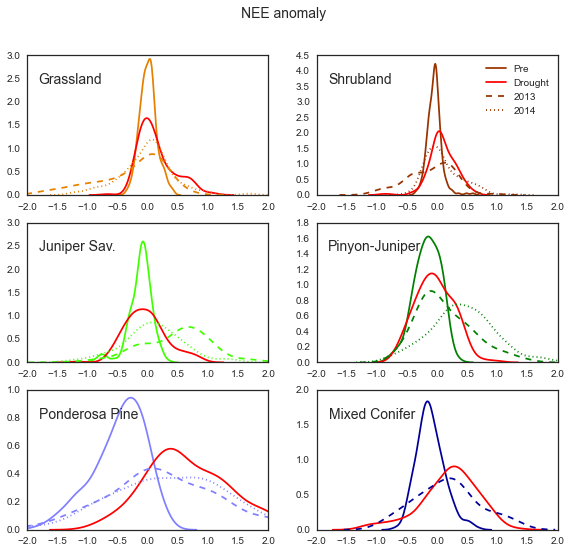

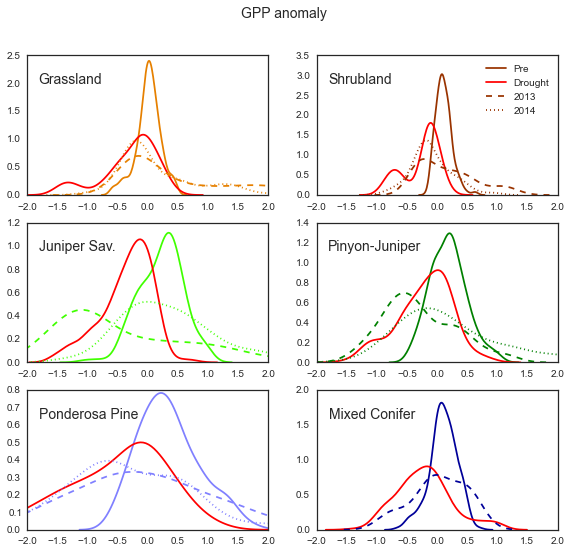

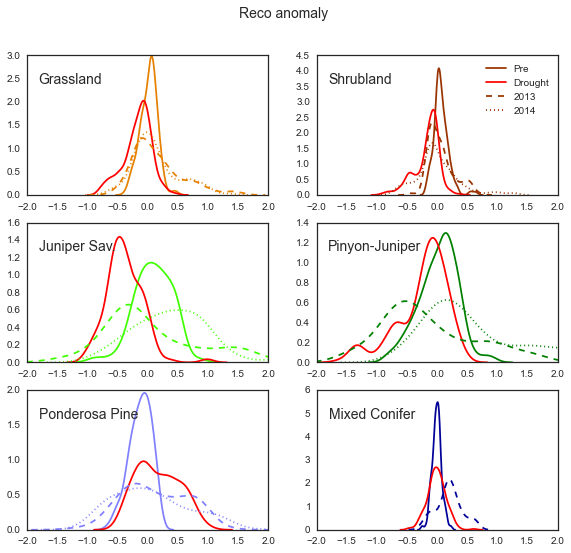

In [20]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, anom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, anom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, anom=True)
plt.suptitle('Reco anomaly', size=14)

## Histograms/KDEs of daily anomaly (wrt pre-drought years)

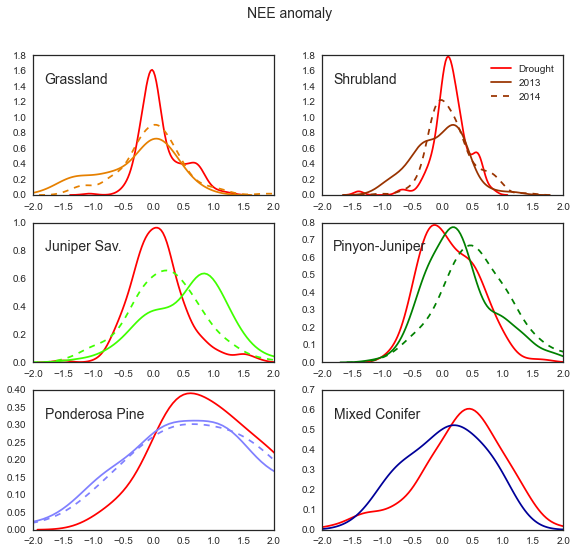

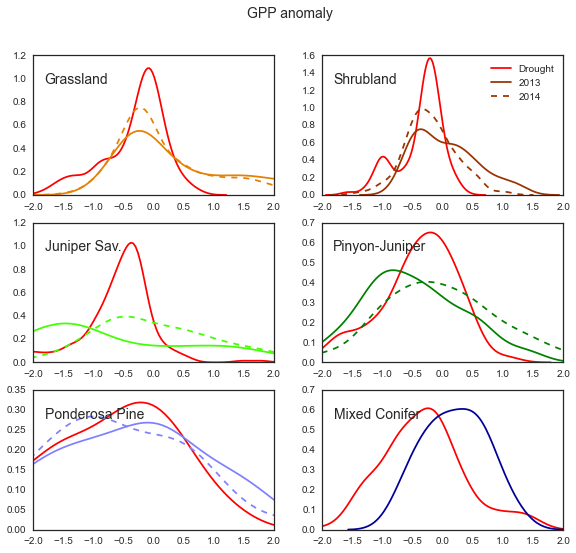

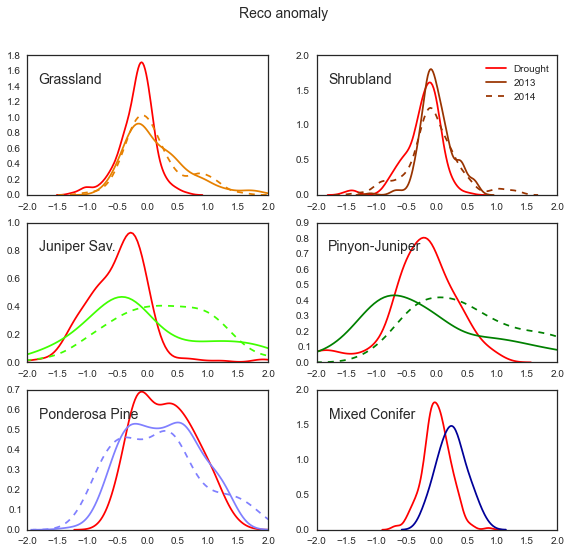

In [21]:
figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(fc_clim, figX, preanom=True)
plt.suptitle('NEE anomaly', size=14)
    
figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(gpp_clim, figY, preanom=True)
plt.suptitle('GPP anomaly', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_drought_kde(re_clim, figZ, preanom=True)
plt.suptitle('Reco anomaly', size=14)

## Cumulative sums by year

These show cumulative C flux (NEE or GPP) for each year measured.

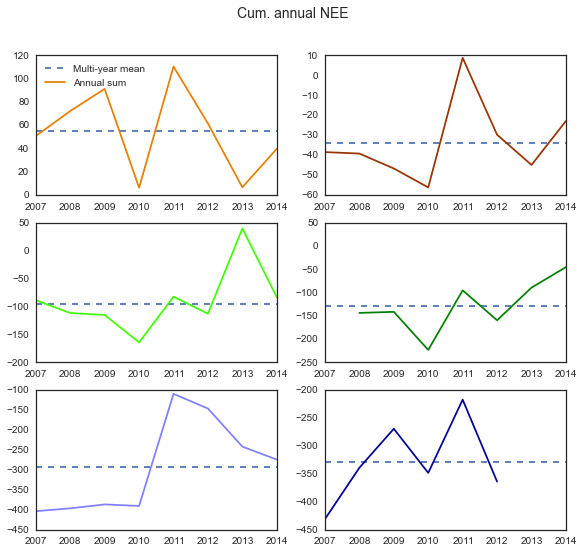

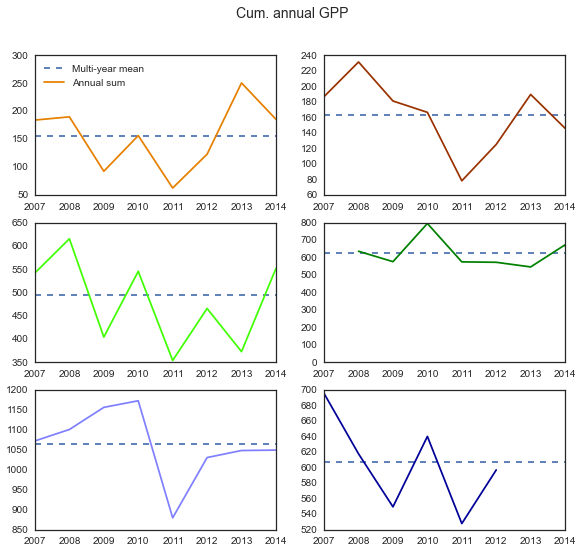

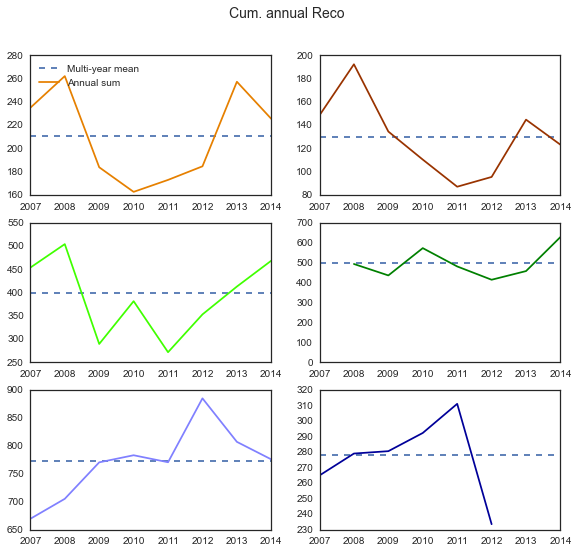

In [22]:
def plot_cumulative_annual( daily_var, clim, fig ):
    for i, site in enumerate(sites):
        ax = fig.add_subplot(3, 2, i+1)
        data = d[site][ daily_var ].groupby(d[site].index.year).sum()
        mean = clim[site].allyr_mean.sum()
        plt.plot([data.index[0], data.index[-1]], [mean, mean], ls='--')
        if site == 'Vcm':
            data = data[data.index < 2013]
        elif site == 'Mpj':
            data = data[data.index > 2007]  
        else:
            data = data[data.index < 2015]
        plt.plot(data.index, data, color=nmegplt.palette[i])
        
        if i == 0:
            plt.legend(['Multi-year mean', 'Annual sum'], loc='upper left')
        plt.xlim([2007, 2014])
        x_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
        ax.xaxis.set_major_formatter(x_formatter)
        #print(data.GPP_g_int.sum())

figX = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'FC_F_g_int', fc_clim, figX )
plt.suptitle('Cum. annual NEE', size=14)

figY = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'GPP_g_int', gpp_clim, figY )
plt.suptitle('Cum. annual GPP', size=14)

figZ = plt.figure(figsize=( 9.5, 8.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_annual( 'RECO_g_int', re_clim, figZ )
plt.suptitle('Cum. annual Reco', size=14)


## Table of cumulative values

* Summed g C/m2 during the different periods we are interested in (pre-, post-, drought, and all year means)
* Differences between pre-drought/potential cumulative values and and drought/post-drought periods
* Percentage of pre-drought and potential cumulative flux


In [23]:
indices = ['AllYr Mean', 'Pre','Drought', 'Post', 'Potential', 
           'Pre-Drought', 'Drought % of pre', 'Pre-Post','Post % of pre',
           'Pot.-Drought', 'Drought % of pot.', 'Pot.-Post', 'Post % of pot.']
nee_t = pd.DataFrame(columns=sites, index = indices)
gpp_t = pd.DataFrame(columns=sites, index = indices)
reco_t = pd.DataFrame(columns=sites, index = indices)

for i, site in enumerate(sites):
        
    # Sum up the climatology columns for the site
    sums = fc_clim[site].sum()
    nee_t[site].loc['AllYr Mean'] = sums.allyr_mean
    nee_t[site].loc['Pre'] = sums.predrght_mean
    nee_t[site].loc['Drought'] = sums.drght_mean
    nee_t[site].loc['Post'] = sums.postdrght_mean
    nee_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    nee_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    nee_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    nee_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = gpp_clim[site].sum()
    gpp_t[site].loc['AllYr Mean'] = sums.allyr_mean
    gpp_t[site].loc['Pre'] = sums.predrght_mean
    gpp_t[site].loc['Drought'] = sums.drght_mean
    gpp_t[site].loc['Post'] = sums.postdrght_mean
    gpp_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    gpp_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    gpp_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    gpp_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
    sums = re_clim[site].sum()
    reco_t[site].loc['AllYr Mean'] = sums.allyr_mean
    reco_t[site].loc['Pre'] = sums.predrght_mean
    reco_t[site].loc['Drought'] = sums.drght_mean
    reco_t[site].loc['Post'] = sums.postdrght_mean
    reco_t[site].loc['Pre-Drought'] = sums.predrght_mean - sums.drght_mean
    reco_t[site].loc['Drought % of pre'] = (sums.drght_mean / sums.predrght_mean) * 100
    reco_t[site].loc['Pre-Post'] = sums.predrght_mean - sums.postdrght_mean
    reco_t[site].loc['Post % of pre'] = (sums.postdrght_mean / sums.predrght_mean) * 100
    
nee_t

Seg       Ses       Wjs       Mpj       Vcp       Vcm
AllYr Mean         54.93127 -33.80336 -94.64055 -128.0466 -292.4278 -329.2808
Pre                55.23153 -45.24434 -133.9829 -169.5632 -393.1307 -346.0407
Drought            86.08364 -10.46362 -97.33448 -126.9479 -126.8557 -289.9347
Post               23.20753  -33.8915 -21.58721   -67.162 -257.5641 -11.57211
Potential               NaN       NaN       NaN       NaN       NaN       NaN
Pre-Drought       -30.85211 -34.78072 -36.64839 -42.61532  -266.275 -56.10598
Drought % of pre   155.8596  23.12691  72.64696  74.86759  32.26808   83.7863
Pre-Post             32.024 -11.35284 -112.3957 -102.4012 -135.5666 -334.4685
Post % of pre      42.01863  74.90771  16.11192  39.60883  65.51616  3.344147
Pot.-Drought            NaN       NaN       NaN       NaN       NaN       NaN
Drought % of pot.       NaN       NaN       NaN       NaN       NaN       NaN
Pot.-Post               NaN       NaN       NaN       NaN       NaN       NaN
Post % of pot.          NaN       NaN       NaN       NaN       NaN       NaN

In [24]:
gpp_t

Seg       Ses       Wjs       Mpj       Vcp       Vcm
AllYr Mean         155.7606  163.4122   494.949  626.5803  1064.928  607.2949
Pre                155.9191  191.8007  559.6665   671.204  1127.251  626.3489
Drought            92.88775  101.7905  410.0969  575.3743  955.8478  562.7101
Post               218.2556  167.9215  462.5552  610.8948  1049.451  78.71243
Potential               NaN       NaN       NaN       NaN       NaN       NaN
Pre-Drought        63.03137  90.01021  149.5696  95.82968  171.4029  63.63877
Drought % of pre   59.57432  53.07096  73.27523  85.72272  84.79461  89.83972
Pre-Post          -62.33646  23.87921  97.11126  60.30924  77.79958  547.6365
Post % of pre        139.98  87.54998  82.64837  91.01477  93.09829  12.56687
Pot.-Drought            NaN       NaN       NaN       NaN       NaN       NaN
Drought % of pot.       NaN       NaN       NaN       NaN       NaN       NaN
Pot.-Post               NaN       NaN       NaN       NaN       NaN       NaN
Post % of pot.          NaN       NaN       NaN       NaN       NaN       NaN

In [25]:
reco_t

Seg       Ses       Wjs       Mpj       Vcp       Vcm
AllYr Mean         210.6919  129.6089  400.3085  498.5338  772.4999  278.0141
Pre                211.1506  146.5563  425.6836  501.6408    734.12  280.3082
Drought            178.9714  91.32685  312.7624  448.4265  828.9921  272.7754
Post               241.4631    134.03   440.968  543.7328   791.887  67.14032
Potential               NaN       NaN       NaN       NaN       NaN       NaN
Pre-Drought        32.17926  55.22949  112.9212  53.21436  -94.8721  7.532791
Drought % of pre   84.76005  62.31518  73.47298  89.39194  112.9232  97.31268
Pre-Post          -30.31246  12.52637  -15.2844 -42.09196   -57.767  213.1679
Post % of pre      114.3558  91.45286  103.5906  108.3909  107.8689  23.95232
Pot.-Drought            NaN       NaN       NaN       NaN       NaN       NaN
Drought % of pot.       NaN       NaN       NaN       NaN       NaN       NaN
Pot.-Post               NaN       NaN       NaN       NaN       NaN       NaN
Post % of pot.          NaN       NaN       NaN       NaN       NaN       NaN

## Pre-Post-During Drought calculations

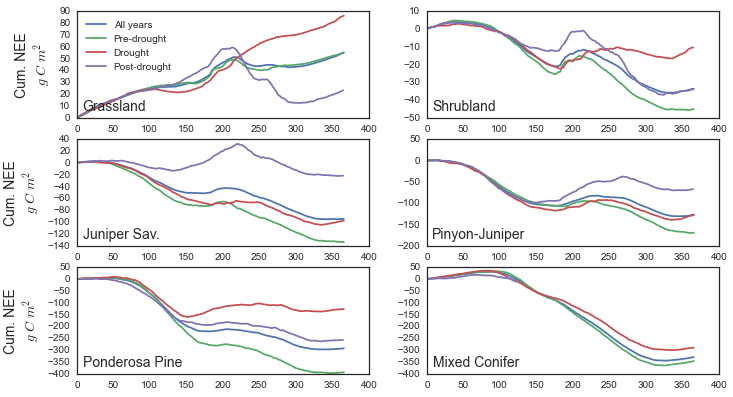

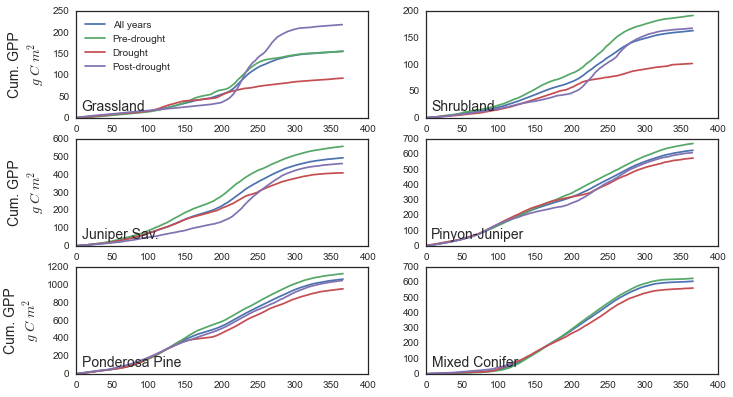

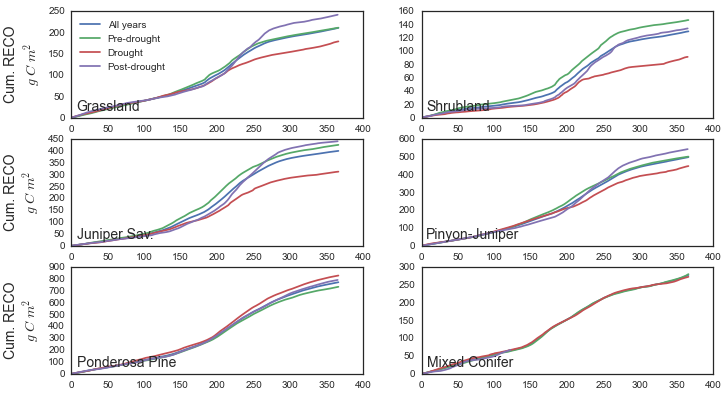

In [26]:
def plot_cumulative_drought( clim, fig, label ):
    ax = list();
    for i, site in enumerate(sites):
        ax.append(fig.add_subplot(3, 2, i+1))
        plt.plot( clim[site].index,  np.cumsum(clim[site].allyr_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].predrght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].drght_mean))
        plt.plot( clim[site].index,  np.cumsum(clim[site].postdrght_mean))
            
        #plt.xlim( xlims )
        plt.text( .02, .07, nmegplt.names[i], size=14, transform=ax[i].transAxes )
        if i==0:
            plt.legend(['All years', 'Pre-drought', 'Drought','Post-drought'], loc='upper left')

    for i in (0, 2, 4):
            ax[i].set_ylabel('Cum. {0}\n$g\ C\ m^2$'.format(label), fontsize=14)
            
figX = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( fc_clim, figX, 'NEE' )

figY = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( gpp_clim, figY, 'GPP' )

figZ = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
plot_cumulative_drought( re_clim, figZ, 'RECO' )

## Plot monthly mean anomalies

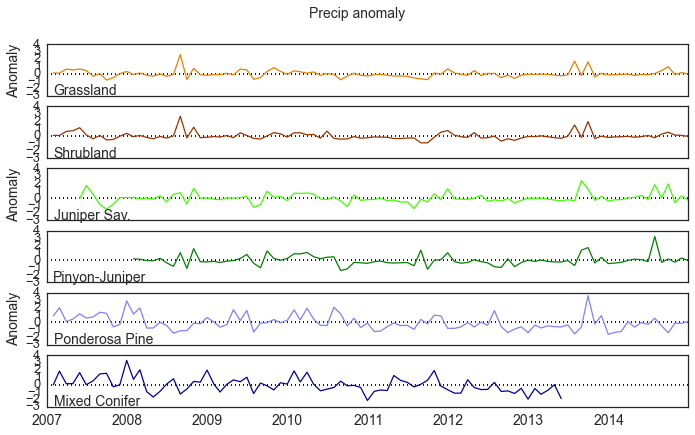

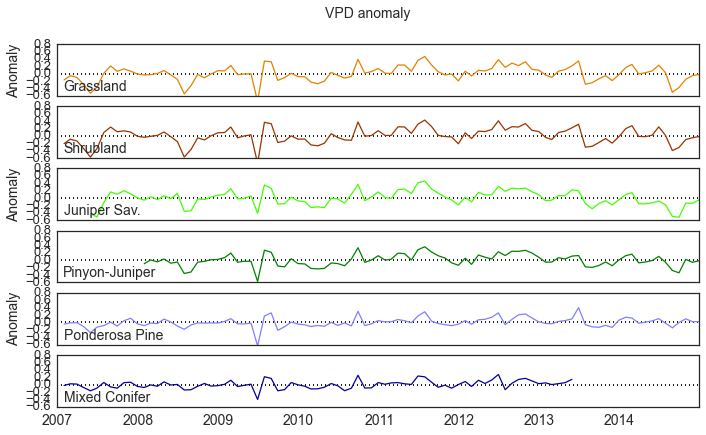

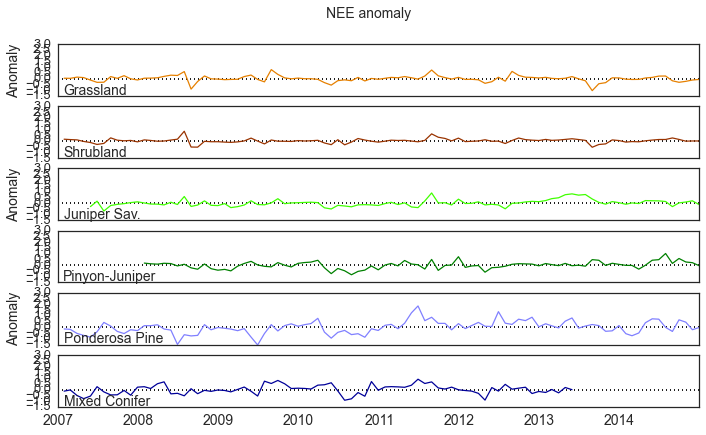

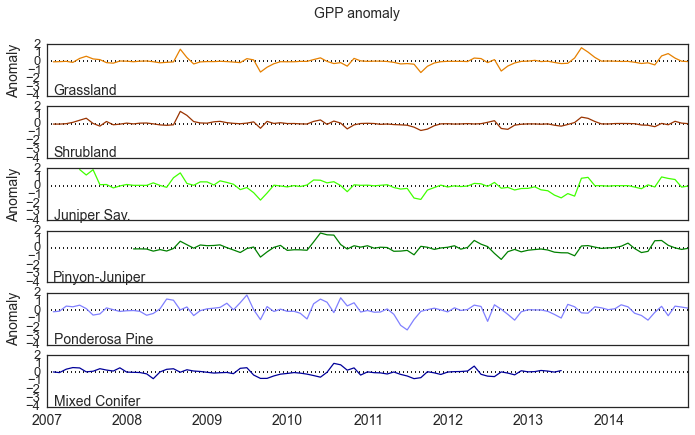

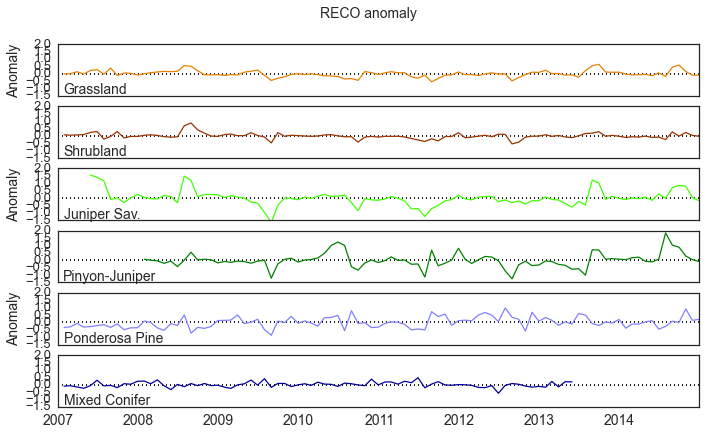

In [27]:
xlims = [ dt.datetime( 2007, 1, 1 ), dt.datetime( 2014, 12, 31 )]

varlist = ['P_F','VPD_F','NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['Precip anomaly', 'VPD anomaly', 'NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-3, 4],[-0.6,0.8],[-1.5,3],[-4,2],[-1.5,2]]

for i, anom in enumerate([p_anom, vpd_anom, fc_anom, gpp_anom, re_anom]):
    # Resample anomaly to monthly mean
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i], size=14)


## Plot monthly mean normalized C flux anomaly

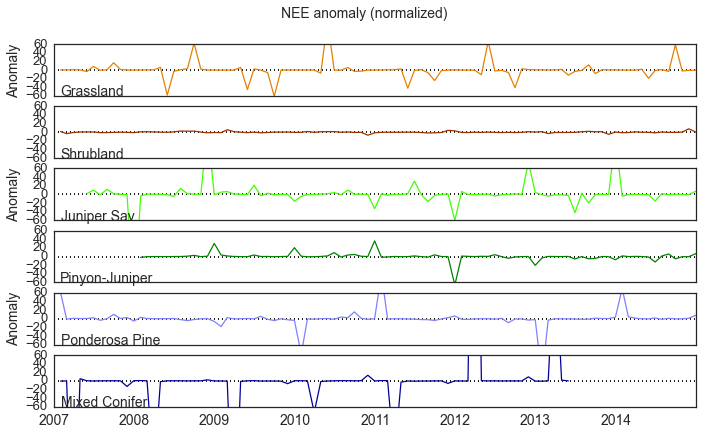

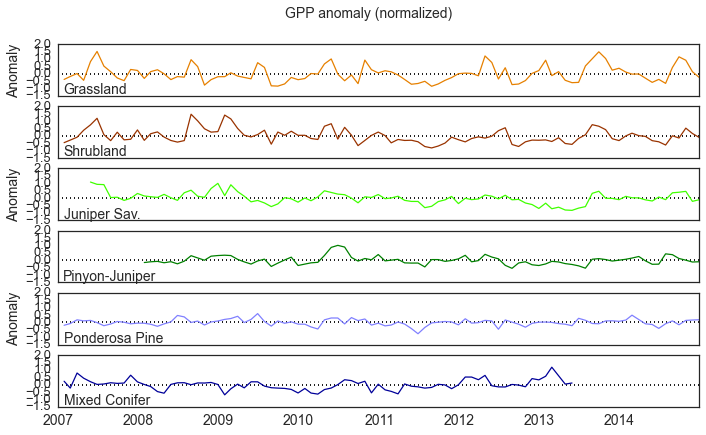

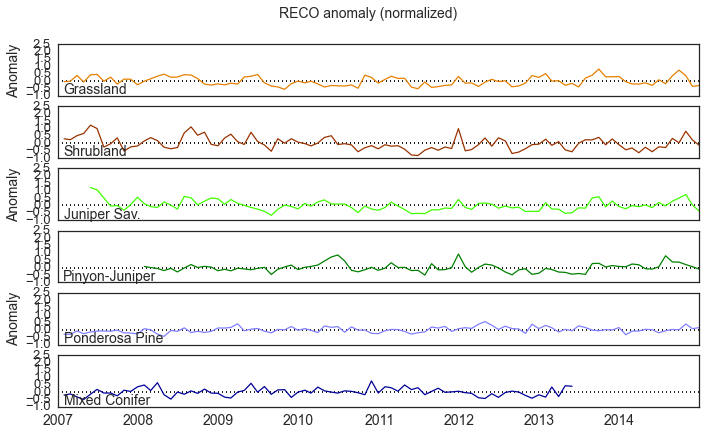

In [28]:
varlist = ['NEE_g_int','GPP_g_int','RECO_g_int']
ylabs = ['NEE anomaly', 'GPP anomaly', 'RECO anomaly']
ylims = [[-60,60],[-1.5,2],[-1,2.5]]

for i, anom in enumerate([fc_anom_n, gpp_anom_n, re_anom_n]):
    
    anom_m = { i : anom[i].resample('1M', how='mean') for i in anom.keys() }
    
    fig = plt.figure(figsize=( 11.5, 6.5 ), dpi=150, facecolor='w', edgecolor='k')
    nmegplt.plot_tseries( anom_m, varlist[i], ylims[i][0]+0.15, fig, 'Anomaly', ylims=ylims[i])
    plt.suptitle(ylabs[i] + ' (normalized)', size=14)
    


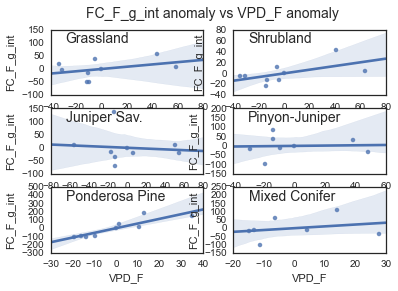

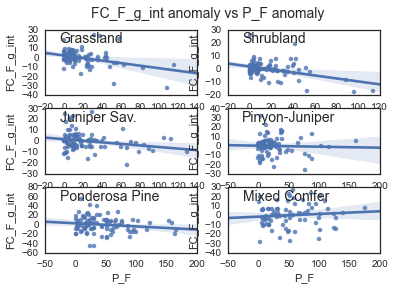

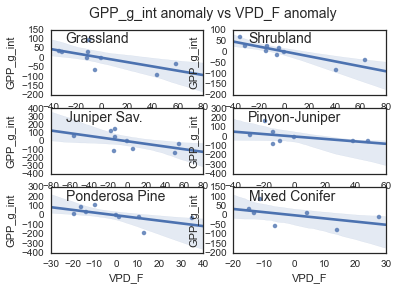

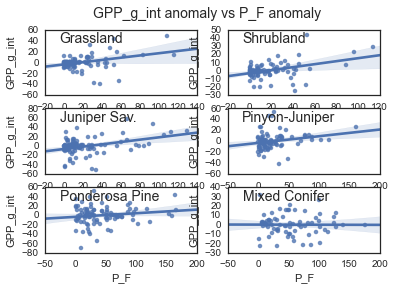

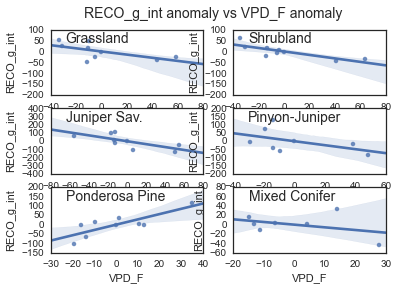

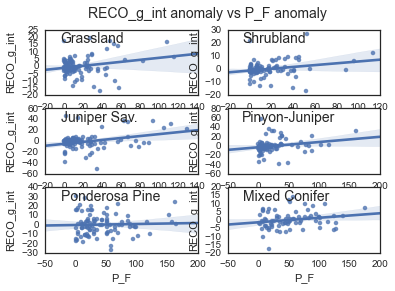

In [29]:
texty = 20
figX = plt.figure()

x_anoms = [vpd_anom, p_anom]
x_labels = ['VPD_F', 'P_F']
y_anoms = [fc_anom, gpp_anom, re_anom]
y_labels = [ 'FC_F_g_int', 'GPP_g_int', 'RECO_g_int']

for i in range(0, 3):
    figA = plt.figure()
    x_anom = x_anoms[0]
    y_anom = y_anoms[i]
    
    for j, site in enumerate(sites):
        x_y_anom = x_anom[ site ].resample('A',how='sum')
        y_y_anom = y_anom[ site ].resample('A',how='sum')
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figA.add_subplot(3, 2, j+1)
        sns.regplot(x_labels[0], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[j], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[0] + ' anomaly', size=14)
    
    figB = plt.figure()
    x_anom = x_anoms[1]
    
    
    for k, site in enumerate(sites):
        # Yearly summed precip
        x_y_anom = d[ site ].P_F.resample('M',how='sum')
        # Yearly summed precip anomaly
        #x_y_anom = x_anom[ site ].resample('M',how='sum')
        y_y_anom = y_anom[ site ].resample('M',how='sum')
        y_y_anom = y_y_anom.shift(-1)
        
        df = pd.concat([x_y_anom, y_y_anom], axis=1)
        ax = figB.add_subplot(3, 2, k+1)
        sns.regplot(x_labels[1], y_labels[i], df)
        plt.text( .1, .8, nmegplt.names[k], size=14, transform = ax.transAxes  )
    plt.suptitle( y_labels[i] + ' anomaly vs ' + x_labels[1] + ' anomaly', size=14)
